We attempt to use KNN model to model our data.

In [1]:
import pandas as pd
import requests
import time
import random
import string
import scipy.stats as stats
import numpy as np
import math 
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
from sklearn.metrics import plot_roc_curve

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from imblearn.pipeline import Pipeline as imbpipeline

In [3]:
# Read in data
train_final = pd.read_csv('./data/train_final.csv')
test_final = pd.read_csv('./data/test_final.csv')

# Set up X_train, y_train, X_test

X_train = train_final.drop(columns = ['Address','Block',
'Street',
'AddressNumberAndStreet',
'Latitude',
'Longitude',
'Species',
'Trap',
'AddressAccuracy',
'tot_mosquitos','WnvPresent','month_year','year', 'month', 'day',
                                     'tarsalis', 'erraticus', 'unspecified',
                                     'T040', 'T200B', 'T234', 'T090A', 'T090C',
                                     'T090B', 'T218C', 'T128A', 'T218B', 'T218A',
                                    'T002A', 'T002B', 'T200A', 'T065A'  ])
y_train = train_final['WnvPresent']
X_test = test_final.drop(columns = ['Address',
'Block',
'Street',
'AddressNumberAndStreet',
'Latitude',
'Longitude',
'Species',
'Trap',
'AddressAccuracy','Id','month_year', 'year', 'month', 'day',
                                   'tarsalis', 'erraticus', 'unspecified',
                                   'T040', 'T200B', 'T234', 'T090A', 'T090C',
                                     'T090B', 'T218C', 'T128A', 'T218B', 'T218A',
                                    'T002A', 'T002B', 'T200A', 'T065A'])

# Scale columns that need to be scaled

ss = StandardScaler()

scale_list = ['StnPressure', 'ResultSpeed','ResultDir',
              'DewPoint', 'DewPoint_roll2','DewPoint_roll3','DewPoint_roll4','DewPoint_roll5', 'DewPoint_roll6',
             'Tavg', 'Tavg_roll2','Tavg_roll3','Tavg_roll4','Tavg_roll5', 'Tavg_roll6',
             'PrecipTotal', 'PrecipTotal_roll2','PrecipTotal_roll3','PrecipTotal_roll4','PrecipTotal_roll5','PrecipTotal_roll6']

X_train[scale_list] = ss.fit_transform(X_train[scale_list])

X_test[scale_list] = ss.transform(X_test[scale_list])

# SMOTE
sm = SMOTE(sampling_strategy = {1: 8000}, random_state = 42)


Xsm, ysm = sm.fit_resample(X_train, y_train)

Xsm_train, Xsm_val, ysm_train, ysm_val = train_test_split(Xsm, 
                                                          ysm,
                                                          test_size= 0.25,
                                                          random_state= 42,
                                                          stratify= ysm)

In [8]:
# Run Gridsearch 
knn = KNeighborsClassifier()

knn_pipe = Pipeline([(
    'knn', KNeighborsClassifier())])

knn_pipe_params = {
    'knn__n_neighbors' : [40, 50, 60, 70],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan']
}

gs = GridSearchCV(knn_pipe,
                 param_grid=knn_pipe_params,
                 cv=5,
                 scoring='roc_auc')

gs.fit(Xsm_train, ysm_train)

gs_model = gs.best_estimator_

In [9]:
# See results
print(f'Best Grid Search Score: {gs.best_score_}')
print(f'Best Params: {gs.best_params_}')

model = gs.best_estimator_
print(f'Best Model Score: {gs_model.score(Xsm_train, ysm_train)}')
print(f'Best Model Test Score: {gs_model.score(Xsm_val,ysm_val)}')


Best Grid Search Score: 0.856535436570122
Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 50}
Best Model Score: 0.7864454350338451
Best Model Test Score: 0.7794008417925229


,0,1
0,Accurary,0.779401
1,Misclassification,0.220599
2,Sensitivity,0.942000
3,Specificity,0.619912
4,Precision,0.708537


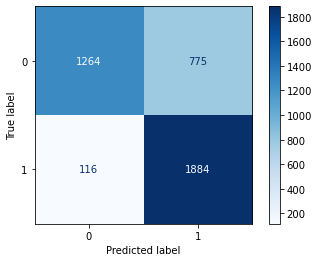

In [10]:
plot_confusion_matrix(gs_model, Xsm_val, ysm_val, cmap='Blues', values_format='d');
tn, fp, fn, tp = confusion_matrix(ysm_val, gs_model.predict(Xsm_val)).ravel()
pd.DataFrame([
    ('Accurary', (tn+tp)/(tn+tp+fp+fn)),
    ('Misclassification', (fp+fn)/(tn+tp+fp+fn)),
    ('Sensitivity', tp/(tp+fn)),
    ('Specificity', tn/(tn+fp)),
    ('Precision', tp/(tp+fp))
])

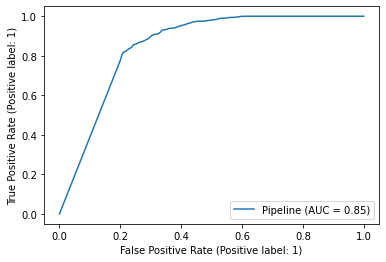

In [11]:
plot_roc_curve(gs_model, Xsm_val, ysm_val);

In [12]:
predict_probas = gs_model.predict_proba(X_test)

In [13]:
predict_predicts = gs_model.predict(X_test)

In [15]:
preds = []
for i in range(0,len(predict_probas)):
    preds.append(predict_probas[i][1])

In [16]:
knn_submission_1 = pd.DataFrame()
knn_submission_1['Id'] = test_final['Id']
knn_submission_1['WnvPresent'] = preds

In [32]:
knn_submission_1.to_csv('./submissions/knn_submission_1.csv', index=False)

When submitted to kaggle, the score is **0.5567**.





When fitting the model to K Nearest Neighbors, the best parameters found were using n = 50 and distance being manhatten.
The best score was 0.7864 and the model score was 0.7794.
When ran on test data, the score on kaggle was 0.5567. This shows that the model was weak and drastically overfitted.

Because KNN has a very limieted concept of probability, its estimate is simplay a fraction of votes amongst nearest neighbors. We can refine it by increasing n but our gridsearch showed that n = 50 was the optimal value. Should the kaggle metric be just simply classification of 1 and 0, our model might have done better in terms of accuracy. However, for such a case, this model was rather unsatisfactory. 

The other main weakness for KNN is that there is little intepretation we can do on the model. We are unable to determine feature importance or intepret coefficients.

## KNN using Imbalance Pipeline

We move on to use imbalance pipeline to prevent any data leakage and see how results fare.

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size= 0.25,
                                                  random_state= 42,
                                                  stratify= y_train)

In [28]:
imbpipe = imbpipeline([('smote', SMOTE(random_state = 42)),
                    ('knn', KNeighborsClassifier())
                   ])

params2 = {
    'knn__n_neighbors' : [40, 50, 60, 70],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan']
}

gs2 = GridSearchCV(imbpipe,
                  param_grid= params2,
                  cv = 5,
                  scoring = 'roc_auc',
                  )

gs2.fit(X_train, y_train)

gs2_model = gs2.best_estimator_

In [29]:
# See results
print(f'Best Grid Search Score: {gs2.best_score_}')
print(f'Best Params: {gs2.best_params_}')

print(f'Best Model Score: {gs2_model.score(X_train, y_train)}')
print(f'Best Model Test Score: {gs2_model.score(X_val,y_val)}')


Best Grid Search Score: 0.782634756834498
Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 40}
Best Model Score: 0.656961437199938
Best Model Test Score: 0.6502554575011612


,0,1
0,Accurary,0.650255
1,Misclassification,0.349745
2,Sensitivity,0.859649
3,Specificity,0.638548
4,Precision,0.117365


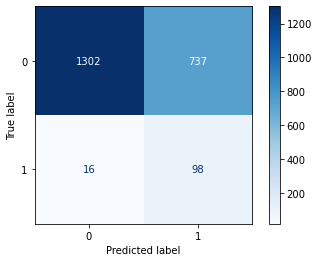

In [30]:
plot_confusion_matrix(gs2_model, X_val, y_val, cmap='Blues', values_format='d');
tn, fp, fn, tp = confusion_matrix(y_val, gs2_model.predict(X_val)).ravel()
pd.DataFrame([
    ('Accurary', (tn+tp)/(tn+tp+fp+fn)),
    ('Misclassification', (fp+fn)/(tn+tp+fp+fn)),
    ('Sensitivity', tp/(tp+fn)),
    ('Specificity', tn/(tn+fp)),
    ('Precision', tp/(tp+fp))
])

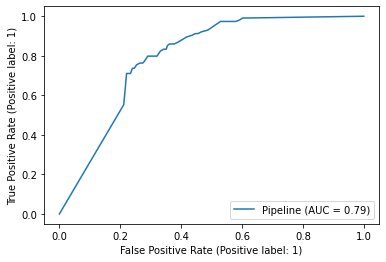

In [31]:
plot_roc_curve(gs2_model, X_val, y_val);

In [33]:
predict_probas = gs2_model.predict_proba(X_test)

preds = []
for i in range(0,len(predict_probas)):
    preds.append(predict_probas[i][1])
    
knn_submission_2 = pd.DataFrame()
knn_submission_2['Id'] = test_final['Id']
knn_submission_2['WnvPresent'] = preds

knn_submission_2.to_csv('./submissions/knn_submission_2.csv', index=False)

We can see that the model score now is 0.65696 and the test score is 0.6502. When submitted to kaggle, the score is 0.53941.

There is no improvement in the score.